# Mask R-CNN

This notebooks shows an example for training Faster R-CNN for deadwood *object detection*

In [1]:
from pathlib import Path
import sys
absolute_path = Path().absolute()
sys.path.append(str(absolute_path.parents[0]))
from drone_detector.utils import *
from drone_detector.visualizations import *

from icevision.all import *

# Read and parse data

In [2]:
parser = parsers.COCOBBoxParser('../data/analysis_data/coco.json', img_dir='../data/analysis_data/raster_tiles/')
class_map = ClassMap(['Standing deadwood', 'Fallen deadwood'])

In [3]:
train, valid = parser.parse()

  0%|          | 0/4044 [00:00<?, ?it/s]

INFO     - Autofixing records | icevision.parsers.parser:parse:126
AUTOFIX-START - ️🔨  Autofixing record with imageid: 291  ️🔨 | icevision.core.record:_pre_replay:89
AUTOFIX-SUCCESS - Clipping bbox ymin from -2.9802322387695312e-08 to 0 (Before: (<BBox (xmin:266.582524782978, ymin:-2.9802322387695312e-08, xmax:348.67602988891304, ymax:67.4379760324955)>)) | icevision.core.bbox:autofix:70
AUTOFIX-START - ️🔨  Autofixing record with imageid: 734  ️🔨 | icevision.core.record:_pre_replay:89
AUTOFIX-SUCCESS - Clipping bbox ymin from -2.9802322387695312e-08 to 0 (Before: (<BBox (xmin:93.39407774433494, ymin:-2.9802322387695312e-08, xmax:98.19294296670705, ymax:1.8044513165950775)>)) | icevision.core.bbox:autofix:70
AUTOFIX-START - ️🔨  Autofixing record with imageid: 430  ️🔨 | icevision.core.record:_pre_replay:89
AUTOFIX-SUCCESS - Clipping bbox ymin from -2.9802322387695312e-08 to 0 (Before: (<BBox (xmin:307.86875058244914, ymin:-2.9802322387695312e-08, xmax:337.9705676427111, ymax:50.677318483

AUTOFIX-SUCCESS - Clipping bbox ymin from -2.9802322387695312e-08 to 0 (Before: (<BBox (xmin:359.8718562545255, ymin:-2.9802322387695312e-08, xmax:373.5666916379705, ymax:7.451094269752502)>)) | icevision.core.bbox:autofix:70
AUTOFIX-START - ️🔨  Autofixing record with imageid: 714  ️🔨 | icevision.core.record:_pre_replay:89
AUTOFIX-SUCCESS - Clipping bbox ymin from -2.9802322387695312e-08 to 0 (Before: (<BBox (xmin:10.065497640520334, ymin:-2.9802322387695312e-08, xmax:30.95247604791075, ymax:20.911456555128098)>)) | icevision.core.bbox:autofix:70
AUTOFIX-START - ️🔨  Autofixing record with imageid: 526  ️🔨 | icevision.core.record:_pre_replay:89
AUTOFIX-SUCCESS - Clipping bbox ymin from -2.9802322387695312e-08 to 0 (Before: (<BBox (xmin:308.0198642555624, ymin:-2.9802322387695312e-08, xmax:318.5659100767225, ymax:31.770385771989822)>)) | icevision.core.bbox:autofix:70
AUTOFIX-SUCCESS - Clipping bbox ymin from -2.9802322387695312e-08 to 0 (Before: (<BBox (xmin:169.67710564564914, ymin:-2.

AUTOFIX-SUCCESS - Clipping bbox ymin from -2.9802322387695312e-08 to 0 (Before: (<BBox (xmin:271.99210712499917, ymin:-2.9802322387695312e-08, xmax:329.18034469988197, ymax:67.82203105092049)>)) | icevision.core.bbox:autofix:70


# Set augmentations, datasets and dataloaders

`tfms.A.aug_tfms` includes various common augmentations, such as rotations, flips and random crops, as well as brightness and contrast augmenting.

In [7]:
train_tfms = tfms.A.Adapter([*tfms.A.aug_tfms(size=(400,400)), tfms.A.Normalize()])
valid_tfms = tfms.A.Adapter([tfms.A.Normalize()])

In [8]:
train_ds = Dataset(train, train_tfms)
valid_ds = Dataset(valid, valid_tfms)

In [9]:
train_dl = faster_rcnn.train_dl(train_ds, batch_size=16, shuffle=True, num_workers=4)
valid_dl = faster_rcnn.valid_dl(valid_ds, batch_size=16, shuffle=False, num_workers=4)

# Init model

We use Faster R-CNN with pretrained ResNet50-backbone. IceVision provides easy way to do this.

In [10]:
metrics = [COCOMetric(metric_type=COCOMetricType.bbox)]
model = faster_rcnn.model(num_classes=len(class_map))

Make a fastai learner

In [11]:
learn = faster_rcnn.fastai.learner(dls=[train_dl, valid_dl], model=model, metrics=metrics)

Search for optimal learning rate for fine_tune

SuggestedLRs(lr_min=0.0002511886414140463, lr_steep=8.31763736641733e-06)

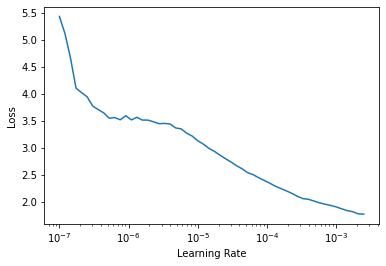

In [12]:
learn.lr_find()

# Train model

Train model quickly with 3e-3 as the maximum learning rate.

In [13]:
learn.fine_tune(30, 3e-3, freeze_epochs=3)

# See results

In [14]:
infer_dl = faster_rcnn.infer_dl(valid_ds, batch_size=8)
samples, preds = faster_rcnn.predict_dl(model, infer_dl)

  0%|          | 0/21 [00:00<?, ?it/s]

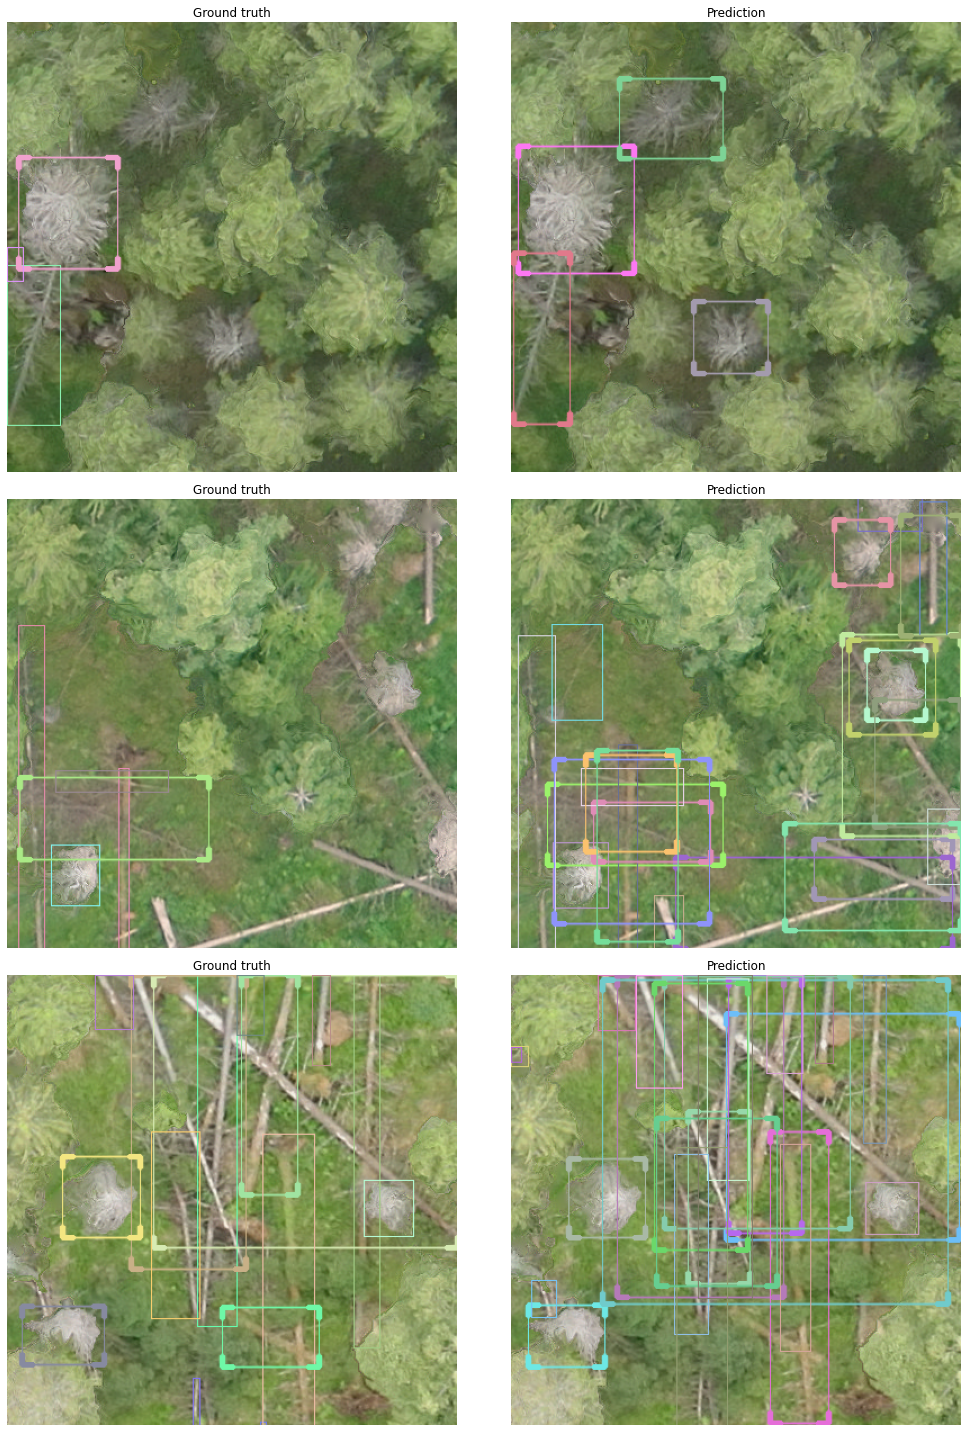

In [15]:
ix = random.randint(0, len(samples)-3)
show_preds(
    samples=samples[ix:ix+3],
    preds=preds[ix:ix+3],
    class_map=class_map,
    denormalize_fn=denormalize_imagenet,
    ncols=2,
    display_label=False,
    display_bbox=True,
    display_mask=False,
    figsize=(15,20)
)

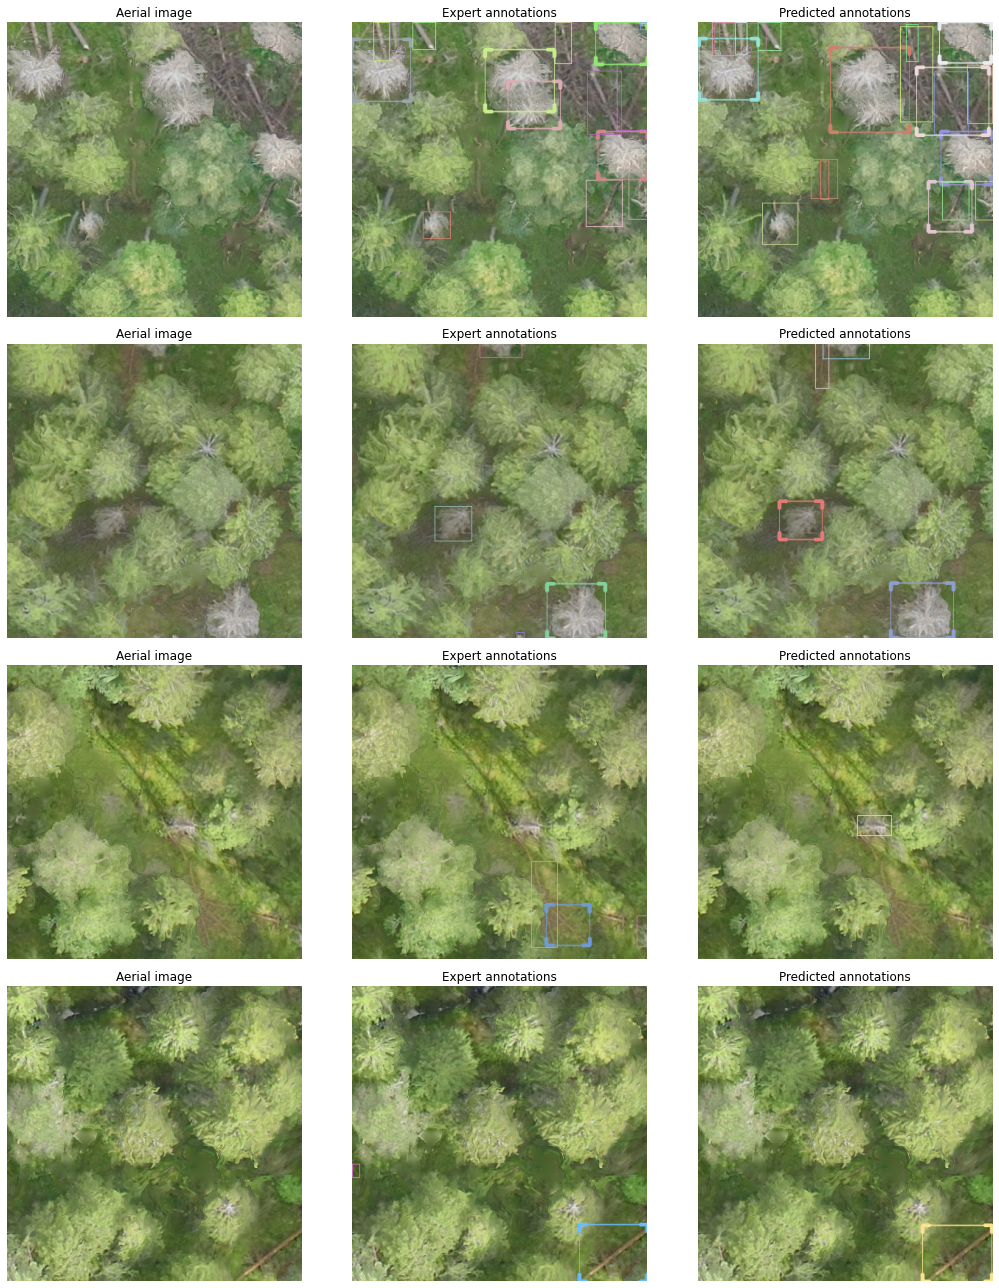

In [17]:
ix = random.randint(0, len(samples)-4)
show_raw_mask_pred(
    samples=samples[ix:ix+4],
    preds=preds[ix:ix+4],
    class_map=class_map,
    denormalize_fn=denormalize_imagenet,
    ncols=3,
    display_label=False,
    display_bbox=True,
    display_mask=False,
    figsize=(15,18)
)

# Tractor is difficult

In [18]:
import PIL

img = np.array(PIL.Image.open('../../deadwood/data/tree_patches_deadwood_sudenpesankangas/R24C17.tif'))

<AxesSubplot:>

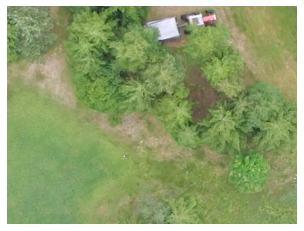

In [19]:
show_img(img)

In [20]:
infer_ds = Dataset.from_images([img], valid_tfms)
infer_dl = faster_rcnn.infer_dl(infer_ds, batch_size=1)
i_samples, i_preds = faster_rcnn.predict_dl(model=model, infer_dl=infer_dl)

  0%|          | 0/1 [00:00<?, ?it/s]

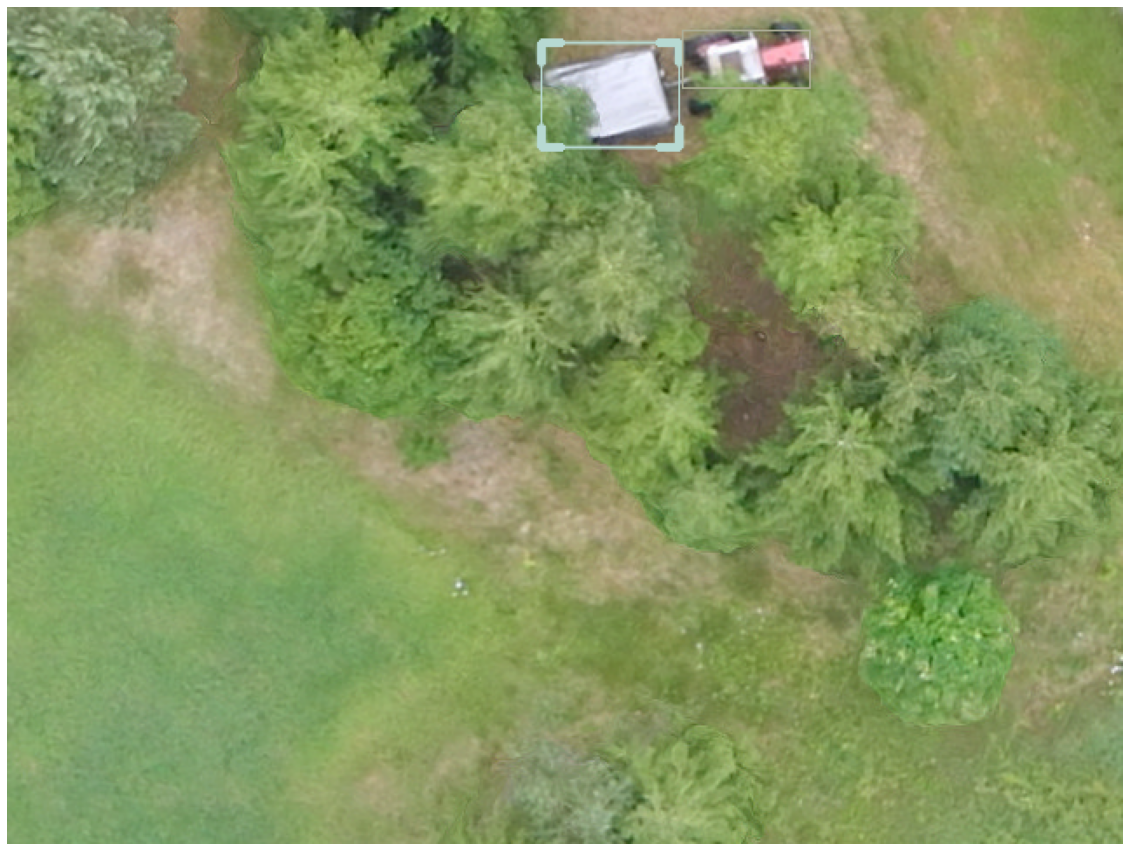

In [21]:
fig, ax = plt.subplots(figsize=(20,18))
show_pred(
    i_samples[0]['img'],
    i_preds[0],
    class_map=class_map,
    denormalize_fn=denormalize_imagenet,
    display_label=False,
    display_bbox=True,
    display_mask=False,
    ax=ax
)

In [22]:
torch.save(model.state_dict(), 'models/faster-rcnn.pth')